# **EN3160 Assignment 2 on Fitting and Alignment**
200417M NAZAR F. S. | https://github.com/Saeedha-N/Fitting-and-Alignment-Assignment

Parameters of the largest circle:
 Center: (110, 258), Radius: 15, Sigma value: 2.0


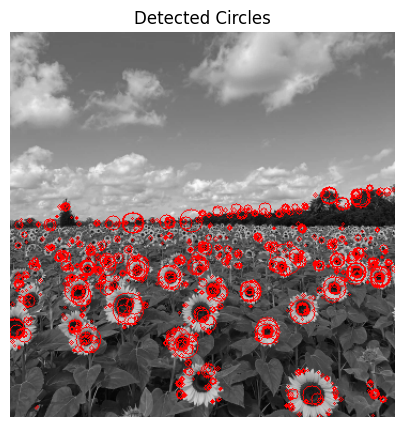

In [4]:
#Q1
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the sunflower field image
image = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Set up parameters for scale-space extrema detection
minimum_sigma = 1.0  # Minimum sigma value (smaller values for smaller blobs)
maximum_sigma = 2.0  # Maximum sigma value (larger values for larger blobs)
sigma_num_values = 5 # Number of sigma values to test
threshold = 0.35  # Threshold for blob detection

# Create an empty list to store detected circles
circles = []

# Loop through different sigma values to detect blobs at different scales
for sigma in np.linspace(minimum_sigma, maximum_sigma, sigma_num_values):
    # Apply LoG (Laplacian of Gaussian) to the grayscale image with the current sigma
    blurred = cv.GaussianBlur(gray_image, (0, 0), sigma)
    laplacian = cv.Laplacian(blurred, cv.CV_64F)
    abs_laplacian = np.abs(laplacian) # Calculate the absolute Laplacian values

    blob_mask = abs_laplacian > threshold * abs_laplacian.max() # Create a binary image where blobs are detected using the threshold
    contours, _ = cv.findContours(blob_mask.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) # Find contours in the blob mask
 
    # Loop through the detected contours and fit circles to them
    for contour in contours:
        if len(contour) >= 5:
            (x, y), radius = cv.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            circles.append((center, radius, sigma))

circles.sort(key=lambda x: -x[1]) # Sort the detected circles by radius in descending order

# Report the parameters of the largest circle
largest_circle = circles[0]
center, radius, sigma = largest_circle
print("Parameters of the largest circle:\n", f"Center: {center}, Radius: {radius}, Sigma value: {sigma}")
line_thickness = 1 # Set the desired line thickness for drawn circles

# Draw all detected circles with the specified line thickness
output_image = cv.cvtColor(gray_image, cv.COLOR_GRAY2BGR)
for circle in circles:
    center, radius, _ = circle
    cv.circle(output_image, center, radius, (0, 0, 255), line_thickness)  # Red color

# Display the grayscale image with detected circles using matplotlib
plt.figure(figsize=(5, 5)), plt.imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB), cmap='gray'), plt.axis('off'), plt.title('Detected Circles')
plt.show()

We can see that many blobs in one sunflower and the trees far away even though the intention was to only detect a blob per sunflower. To improve the accuracy of the code, we could try using a narrower range of sigma values, a different blob detection algorithm such as the Difference of Gaussians (DOG) algorithm since it is relatively less sensitive to noise, or use a post-processing step to filter out the detected blobs that are not likely to be sunflower heads. 

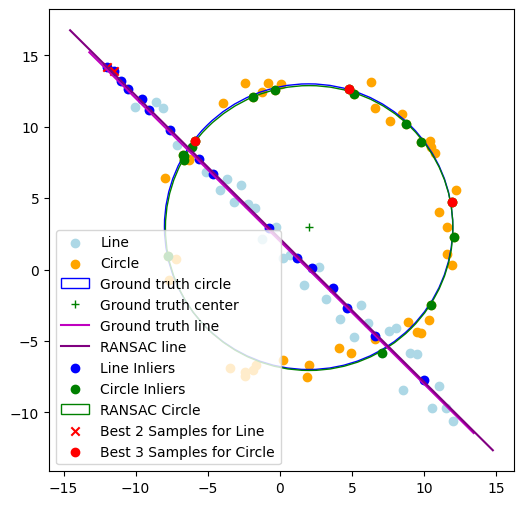

In [11]:
#Q2
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize

np.random.seed(1) # Seed for reproducibility

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center of the circle
s = r / 16

# Generate points for the circle
theta = np.random.uniform(0, 2 * np.pi, half_n)
noise = s * np.random.randn(half_n)
x_circle = x0_gt + (r + noise) * np.cos(theta)
y_circle = y0_gt + (r + noise) * np.sin(theta)
X_circle = np.column_stack((x_circle, y_circle))

# Generate points for the line
s = 1.0
m, b = -1, 2
x_line = np.linspace(-12, 12, half_n)
y_line = m * x_line + b + s * np.random.randn(half_n)
X_line = np.column_stack((x_line, y_line))

# Concatenate points from both circle and line to create X
X = np.vstack((X_circle, X_line))

# Plot the noisy points, ground truth line, and ground truth circle
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(X_line[:, 0], X_line[:, 1], color = 'lightblue', label='Line')
ax.scatter(X_circle[:, 0], X_circle[:, 1], color = 'orange', label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='blue', fill=False, label='Ground truth circle')
ax.add_artist(circle_gt)
ax.plot(x0_gt, y0_gt, '+g', label='Ground truth center')
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = m * x_range + b
plt.plot(x_range, y_range, color='m', label='Ground truth line')

# Define a function to calculate the line equation from two points
def line_eq_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    return a, b, d

# RANSAC to fit a line with unit normal constraint
def RANSAC_line(X, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(X), 2, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        
        a, b, d = line_eq_from_points(x1, y1, x2, y2)
        
        # Constraint: Ensure unit normal vector
        magnitude = np.sqrt(a**2 + b**2)
        a /= magnitude
        b /= magnitude
        
        # Calculate the distance of all points to the line
        distances = np.abs(a*X[:,0] + b*X[:,1] - d)
        
        # Find inliers based on the threshold
        inliers = np.where(distances < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (a, b, d)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters
iterations = 10000
threshold = 0.15
min_inliers = 15

# Estimate the line using RANSAC
best_line_model, Line_inlier_indices = RANSAC_line(X_line, iterations, threshold, min_inliers)

# Define a function to calculate the circle equation from three points
def circle_eq_from_points(x1, y1, x2, y2, x3, y3):
    # Calculate the midpoints of two line segments
    mx1, my1 = (x1 + x2) / 2, (y1 + y2) / 2
    mx2, my2 = (x2 + x3) / 2, (y2 + y3) / 2
    
    # Calculate the slopes of the two lines
    if y2 - y1 == 0: slope1 = 0  # Avoid division by zero
    else:
        slope1 = (x2 - x1) / (y2 - y1)
    
    if y3 - y2 == 0: slope2 = 0  # Avoid division by zero
    else: slope2 = (x3 - x2) / (y3 - y2)
    
    # Calculate the center of the circle
    x_center = (slope1 * mx1 - slope2 * mx2 + my2 - my1) / (slope1 - slope2)
    y_center = -slope1 * (x_center - mx1) + my1

    radius = np.sqrt((x1 - x_center)**2 + (y1 - y_center)**2) # Calculate the radius
    
    return x_center, y_center, radius

# RANSAC to fit a circle
def RANSAC_circle(X, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(X), 3, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        x3, y3 = X[sample_indices[2]]
        
        x_center, y_center, radius = circle_eq_from_points(x1, y1, x2, y2, x3, y3)
        
        # Calculate the radial error of all points to the circle
        errors = np.abs(np.sqrt((X[:, 0] - x_center)**2 + (X[:, 1] - y_center)**2) - radius)
        
        # Find inliers based on the threshold
        inliers = np.where(errors < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (x_center, y_center, radius)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters for circle estimation
circle_iterations = 10000
circle_threshold = 0.2  # Adjust the threshold as needed
circle_min_inliers = 15

# Identify the remnant points (not explained by the line)
remaining_indices = [i for i in range(len(X)) if i not in Line_inlier_indices]
remaining_points = X[remaining_indices]

# Estimate the circle using RANSAC
best_circle_model, circle_inlier_indices = RANSAC_circle(remaining_points, circle_iterations, circle_threshold, circle_min_inliers)

# Plot the estimated line
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = (-best_line_model[0] * x_range + best_line_model[2]) / best_line_model[1]
plt.plot(x_range, y_range, label='RANSAC line', color='purple')

ax.scatter(X_line[Line_inlier_indices, 0], X_line[Line_inlier_indices, 1], color='blue', label='Line Inliers')

# Find the best 2 samples for the line
best_line_sample_indices = Line_inlier_indices[:2]
best_line_samples = X_line[best_line_sample_indices]

# Plot the inliers of the circle
ax.scatter(remaining_points[circle_inlier_indices, 0], remaining_points[circle_inlier_indices, 1], color='g', label='Circle Inliers')

# Plot the estimated circle
x_center, y_center, radius = best_circle_model
circle_estimated = plt.Circle((x_center, y_center), radius, color='g', fill=False, label='RANSAC Circle')
ax.add_artist(circle_estimated)

# Find the best 3 samples for the circle (using circle_inlier_indices)
best_circle_sample_indices = circle_inlier_indices[:3]
best_circle_samples = remaining_points[best_circle_sample_indices]

# Plot the best 2 samples for the line and the best 3 samples for the circle
ax.scatter(best_line_samples[:, 0], best_line_samples[:, 1], color='red', marker='x', label='Best 2 Samples for Line')
ax.scatter(best_circle_samples[:, 0], best_circle_samples[:, 1], color='red', marker='o', label='Best 3 Samples for Circle')

plt.legend()
plt.show()

Original noisy points (blue and orange): Given data points that are noisy in the sense that they contain both inliers and outliers.

Estimated line (purple): This is the line that was fit to the inliers of the data points using the RANSAC algorithm.

Inliers of the line (blue): Data points that lie within a certain distance of the estimated line, considered to be part of the line model.

Estimated circle (green): This is the circle that was fit to the inliers of the data points using the RANSAC algorithm.

Inliers of the circle (green): Data points that lie within a certain distance of the estimated circle, which is part of the circle model.

Best 2 samples for the line (red x): The 2 data points that were used to estimate the line model, chosen to minimize the distance between the line and the inliers.

Best 3 samples for the circle (red o): The 3 data points that were used to estimate the circle model, chosen to minimize the distance between the circle and the inliers.

If we fit the circle first, we may not be able to accurately estimate the parameters of the circle, as the data points will be scattered around the circle due to the noise. The line fit may also be affected, as the data points will not be perfectly aligned with a line after the circle fit has been subtracted.

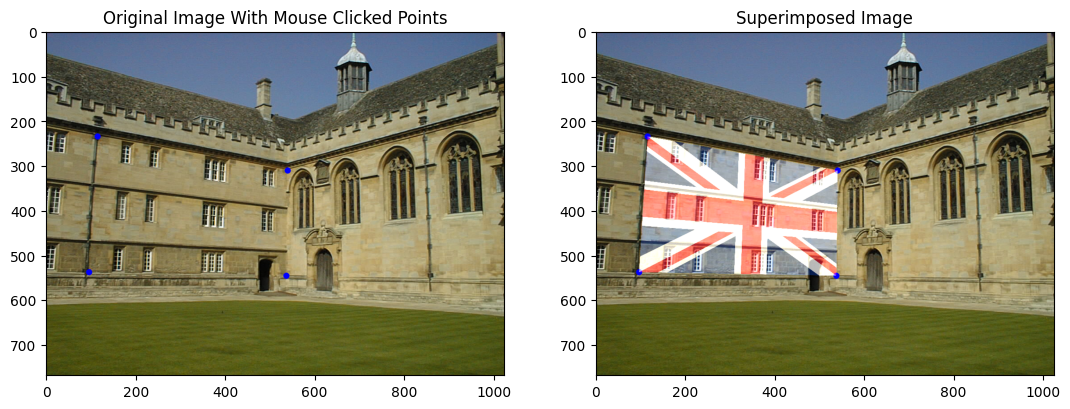

In [6]:
#Q3
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

counter = 0 # Counter to keep track of the number of points clicked
number_of_points = 4 # Maximum number of points to be clicked
building_points = np.empty((number_of_points,2)) # Empty array to store the points clicked

# Load the building and flag images
building = cv.imread('building.jpg', cv.IMREAD_COLOR)
UK_flag = cv.imread('UK_flag.png', cv.IMREAD_COLOR)

# Define mouse callback function to get the mouse points of the building image
def draw_circle(event, x, y, flags, img): # Event is the type of mouse event, x and y are the coordinates of the mouse pointer, flags is the additional flags associated with the image, img is the user-defined building that is passed
    global counter
    if event == cv.EVENT_LBUTTONDOWN: # Checks if left mouse button is pressed
        cv.circle(img, (x,y), 7, (255, 0, 0), -1) # Draws a circle at the mouse pointer, -1 means the circle should be filled, (255, 0, 0) is the blue color of the circle in BGR
        building_points[counter] = (x,y) 
        counter += 1

# Getting the mouse points of the building image
cv.namedWindow('Base Image', cv.WINDOW_AUTOSIZE) # Creates a window with the name 'Base Image'
cv.setMouseCallback('Base Image', draw_circle, building) # Calls the callback function when a mouse event occurs, building is the user-defined parameter that is passed
while(True):
    cv.imshow('Base Image', building) 
    if counter == number_of_points: # Checks if the number of points clicked is equal to the maximum number of points
        break
    if cv.waitKey(20) & 0xFF == 27: # Checks if the 'Esc' key is pressed
        break

# Define the corresponding points on the flag image
flag_points = np.array([[0, 0], [UK_flag.shape[1], 0], [UK_flag.shape[1], UK_flag.shape[0]], [0, UK_flag.shape[0]]], dtype=np.float32)

# Find the homography matrix
homography_matrix, _ = cv.findHomography(flag_points, building_points)

# Warp the flag image to match the the building points using the homography matrix
flag_warped = cv.warpPerspective(UK_flag, homography_matrix, (building.shape[1], building.shape[0]))

# Blend the two images
blended_image = cv.addWeighted(building, 1, flag_warped, 0.7, 0)

# Display the result using OpenCV
cv.imshow('Superimposed Image', blended_image)
cv.imwrite('superimposed_flag_building.png', blended_image) # Save the image
cv.waitKey(0)
cv.destroyAllWindows()

# Display the mouse clicked original and superimposed image using matplotlib
plt.figure(figsize=(13, 13))
plt.subplot(1,2,1), plt.imshow(cv.cvtColor(building, cv.COLOR_BGR2RGB)) # The last parameter in plt.subplot() is the current index of the subplot
plt.title('Original Image With Mouse Clicked Points')
plt.subplot(1,2,2), plt.imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB)), plt.title('Superimposed Image')
plt.show()

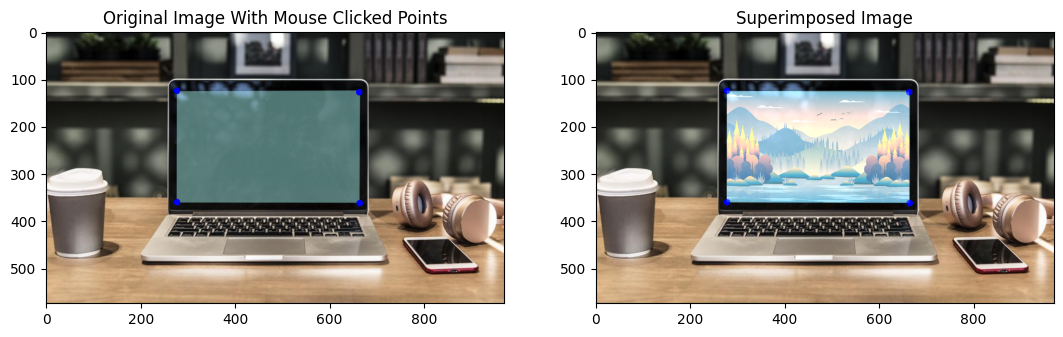

In [7]:
counter = 0 # Counter to keep track of the number of points clicked
number_of_points = 4 # Maximum number of points to be clicked
laptop_points = np.empty((number_of_points,2)) # Empty array to store the points clicked

# Load the laptop and wallpaper images
laptop = cv.imread('laptop1.jpg', cv.IMREAD_COLOR)
wallpaper = cv.imread('wallpaper.jpg', cv.IMREAD_COLOR)

# Define mouse callback function to get the mouse points of the laptop image
def draw_circle(event, x, y, flags, img): # Event is the type of mouse event, x and y are the coordinates of the mouse pointer, flags is the additional flags associated with the image, img is the user-defined laptop that is passed
    global counter
    if event == cv.EVENT_LBUTTONDOWN: # Checks if left mouse button is pressed
        cv.circle(img, (x,y), 7, (255, 0, 0), -1) # Draws a circle at the mouse pointer, -1 means the circle should be filled, (255, 0, 0) is the blue color of the circle in BGR
        laptop_points[counter] = (x,y) 
        counter += 1

# Getting the mouse points of the laptop image
cv.namedWindow('Base Image', cv.WINDOW_AUTOSIZE) # Creates a window with the name 'Base Image'
cv.setMouseCallback('Base Image', draw_circle, laptop) # Calls the callback function when a mouse event occurs, laptop is the user-defined parameter that is passed
while(True):
    cv.imshow('Base Image', laptop) 
    if counter == number_of_points: # Checks if the number of points clicked is equal to the maximum number of points
        break
    if cv.waitKey(20) & 0xFF == 27: # Checks if the 'Esc' key is pressed
        break

# Define the corresponding points on the flag image
wallpaper_points = np.array([[0, 0], [wallpaper.shape[1], 0], [wallpaper.shape[1], wallpaper.shape[0]], [0, wallpaper.shape[0]]], dtype=np.float32)

# Find the homography matrix
homography_matrix, _ = cv.findHomography(wallpaper_points, laptop_points)

# Warp the wallpaper image to match the the laptop points using the homography matrix
wallpaper_warped = cv.warpPerspective(wallpaper, homography_matrix, (laptop.shape[1], laptop.shape[0]))

# Blend the two images
blended_image = cv.addWeighted(laptop, 1, wallpaper_warped, 0.9, 0)

# Display the result using OpenCV
cv.imshow('Superimposed Image', blended_image)
cv.imwrite('superimposed_laptop_wallpaper.png', blended_image) # Save the image
cv.waitKey(0)
cv.destroyAllWindows()

# Display the mouse clicked original and superimposed image using matplotlib
plt.figure(figsize=(13, 13))
plt.subplot(1,2,1), plt.imshow(cv.cvtColor(laptop, cv.COLOR_BGR2RGB)) # The last parameter in plt.subplot() is the current index of the subplot
plt.title('Original Image With Mouse Clicked Points')
plt.subplot(1,2,2), plt.imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB)), plt.title('Superimposed Image')
plt.show()

When the mouse points are NOT clicked in order (i.e. clockwise or anti-clockwise) the flag gets superimposed outside the rectangular shape given by the mouse clicked points. 

The interactive point selection on the building image helps conveniently define a planar surface for precise superimposition. The computed homography matrix effectively corrects perspective differences, ensuring that the UK flag image seamlessly integrates with the building.

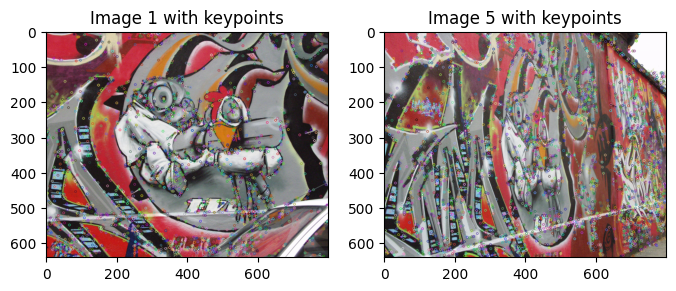

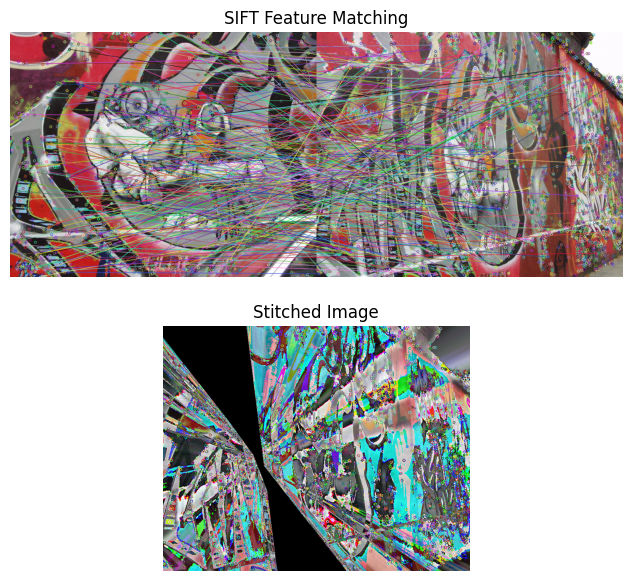

Homography Matrix:
 [[ 7.48482833e-01 -1.02674036e+00  1.68691518e+02]
 [ 1.06633656e+00 -1.44279067e+00  2.44987291e+02]
 [ 2.83151482e-03 -4.46537392e-03  1.00000000e+00]]


In [60]:
#Q4
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the images
img_1 = cv.imread('graf/img1.ppm', cv.IMREAD_COLOR)
img_5 = cv.imread('graf/img5.ppm', cv.IMREAD_COLOR)

# Find the keypoints and descriptors with SIFT
keypoints_1, descriptors_1 = cv.SIFT_create().detectAndCompute(img_1, None)
keypoints_5, descriptors_5 = cv.SIFT_create().detectAndCompute(img_5, None)

# Draw keypoints
img1_with_keypoints = cv.drawKeypoints(img_1, keypoints_1, img_1)
img5_with_keypoints = cv.drawKeypoints(img_5, keypoints_5, img_5)

# Show Images
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1), plt.imshow(cv.cvtColor(img1_with_keypoints, cv.COLOR_BGR2RGB)), plt.title('Image 1 with keypoints')
plt.subplot(1, 2, 2), plt.imshow(cv.cvtColor(img5_with_keypoints, cv.COLOR_BGR2RGB)), plt.title('Image 5 with keypoints')
plt.show()

# Match keypoints between images
brute_force = cv.BFMatcher() #Create a Brute-Force Matcher object
matches = brute_force.knnMatch(descriptors_1, descriptors_5, k=2) # Find the 2 best matches for each descriptor, k=2 means 2 best matches 

# Apply ratio test
potential_matches = []
for best_match, second_best_match in matches: 
    if best_match.distance < 0.85 * second_best_match.distance: # Checks if the distance of the best match is less than 0.85 times the distance of the second best match
        potential_matches.append(best_match)

# Draw the matches
matched_image = cv.drawMatches(img_1, keypoints_1, img_5, keypoints_5, potential_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Extract the coordinates of matched keypoints from both images
src_pts = np.float32([keypoints_1[m.queryIdx].pt for m in potential_matches]).reshape(-1, 1, 2) # m.queryIdx is the index of the descriptor in the query descriptors
dst_pts = np.float32([keypoints_5[m.trainIdx].pt for m in potential_matches]).reshape(-1, 1, 2) # m.trainIdx is the index of the descriptor in the train descriptors

# Compute the homography using RANSAC
homography_matrix, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0) # 5.0 is the maximum allowed reprojection error

# Warp 'img1.ppmm' onto 'img5.ppm' using the computed homography
stitched_image = cv.warpPerspective(img_1, homography_matrix, (img_5.shape[1], img_5.shape[0]))

# Create a mask to combine the two images
mask = (stitched_image == 0) # Create a mask of the stitched image
stitched_image += img_5 # Add the first image to the stitched image
stitched_image[mask] = 0 # Set the pixels of the stitched image that are not part of the second image to 0

# Show Images
plt.figure(figsize=(12, 7))
plt.subplot(2, 1, 1), plt.imshow(cv.cvtColor(matched_image, cv.COLOR_BGR2RGB)), plt.axis('off'), plt.title('SIFT Feature Matching')
plt.subplot(2, 1, 2), plt.imshow(cv.cvtColor(stitched_image, cv.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Stitched Image')
plt.show()

#print the homography matrix
print("Homography Matrix:\n", homography_matrix)

The issue in the computed homography matrix is likely due to differences in the selection and quality of keypoints, as well as variations in the RANSAC algorithm's behavior, which can lead to a divergence from the expected ideal matrix. The stitched image is distorted likely because the computed homography matrix does not accurately represent the transformation needed to align the images correctly.